In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from bs4 import BeautifulSoup
from lxml import html
from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

### Importing the cleaned data; the data includes energy consumption in MWH for 4 utilities under CAISO- PGE, SCE, VEA and PGE.  For my capstone project, I will focus only on another utility-PGE (Pacific Gas & Electric); selecting smaller region will make it easier in the future to import the weather data and use it as a forecasting parameter. 

In [11]:
#reading in the hourly energy consumption .csv file imported and cleaned using 
#Capstone1_CAISO_hourly_energy_import&clean_data.ipynb
hPGE1418=pd.read_csv('hourly1418CA.csv',usecols=['Dates','PGE'], parse_dates=['Dates'])

In [12]:
#Next few lines: checking the data
hPGE1418.head()

,Dates,PGE
0,2014-01-01 00:00:00,10057.0
1,2014-01-01 01:00:00,9707.0
2,2014-01-01 02:00:00,9438.0
3,2014-01-01 03:00:00,9309.0
4,2014-01-01 04:00:00,9319.0


In [13]:
hPGE1418.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 2 columns):
Dates    43824 non-null datetime64[ns]
PGE      43824 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 684.8 KB


In [14]:
hPGE1418.describe()

,PGE
count,43824.000000
mean,11930.037979
std,1989.259463
min,8245.000000
25%,10499.000000
50%,11671.000000
75%,12818.000000
max,21713.782826


In [6]:
#Since the date column is in object format, converting the Dates column to datetime 
#hPGE1418['Dates']=pd.to_datetime(hPGE1418['Dates'])
#checking info again
#hPGE1418.info()

In [15]:
#Adding weekdays, month, day of the month, hour of the day, year as extra columns; mapping the weekdays to a dict
#to use the actual weekdays in words like 'Monday', etc. Python usually indicates Monday as 0, Tuesday as 1 and so on. 
weekdays={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5:'Saturday', 6:'Sunday'}
hPGE1418['Date']= pd.to_datetime(hPGE1418.Dates.dt.date)
hPGE1418['year']=hPGE1418.Dates.dt.year
hPGE1418['month']=hPGE1418.Dates.dt.month
hPGE1418['day']=hPGE1418.Dates.dt.day
hPGE1418['hour']=hPGE1418.Dates.dt.hour
hPGE1418['weekday']=hPGE1418.Dates.dt.weekday.map(weekdays)

In [16]:
#Checking the data
hPGE1418.head()

,Dates,PGE,Date,year,month,day,hour,weekday
0,2014-01-01 00:00:00,10057.0,2014-01-01,2014,1,1,0,Wednesday
1,2014-01-01 01:00:00,9707.0,2014-01-01,2014,1,1,1,Wednesday
2,2014-01-01 02:00:00,9438.0,2014-01-01,2014,1,1,2,Wednesday
3,2014-01-01 03:00:00,9309.0,2014-01-01,2014,1,1,3,Wednesday
4,2014-01-01 04:00:00,9319.0,2014-01-01,2014,1,1,4,Wednesday


In [17]:
hPGE1418.tail()

,Dates,PGE,Date,year,month,day,hour,weekday
43819,2018-12-31 19:00:00,11638.162780,2018-12-31,2018,12,31,19,Monday
43820,2018-12-31 20:00:00,11240.842142,2018-12-31,2018,12,31,20,Monday
43821,2018-12-31 21:00:00,10846.176249,2018-12-31,2018,12,31,21,Monday
43822,2018-12-31 22:00:00,10499.475128,2018-12-31,2018,12,31,22,Monday
43823,2018-12-31 23:00:00,10023.052203,2018-12-31,2018,12,31,23,Monday


In [18]:
#Adding holidays column to indicate whether a day was a holiday as per the US calendar or not
cal = calendar()
holidays = cal.holidays(start=hPGE1418['Date'].min(), end=hPGE1418['Date'].max())
hPGE1418['holiday'] = hPGE1418['Date'].isin(holidays)

In [19]:
#checking if holidays were mapped correctly; True should indicate a holiday and False a regular day. Also, if a holiday falls 
#on a weekend it is not marked as a holiday, so the value will be False. 
#hPGE1418[(hPGE1418.month==12) & (hPGE1418.day==25)] #checking the specific holiday of 25th Dec
#hPGE1418.head()

In [20]:
#converting the holiday column to 1 and 0, 1 indicating a holiday and 0 not a holiday; using dictionary and map to achieve this
mapped={True:1, False:0}
hPGE1418.holiday=hPGE1418.holiday.map(mapped)
hPGE1418.head()

,Dates,PGE,Date,year,month,day,hour,weekday,holiday
0,2014-01-01 00:00:00,10057.0,2014-01-01,2014,1,1,0,Wednesday,1
1,2014-01-01 01:00:00,9707.0,2014-01-01,2014,1,1,1,Wednesday,1
2,2014-01-01 02:00:00,9438.0,2014-01-01,2014,1,1,2,Wednesday,1
3,2014-01-01 03:00:00,9309.0,2014-01-01,2014,1,1,3,Wednesday,1
4,2014-01-01 04:00:00,9319.0,2014-01-01,2014,1,1,4,Wednesday,1


In [21]:
#adding in another column which indicates 'non-working' days which include weekends and holidays
hPGE1418['non_working']=hPGE1418.apply(lambda x: 1 if \
                                         ((x['holiday']==1) or (x['weekday'] in ['Saturday', 'Sunday']))
                                         else 0, axis=1)

In [22]:
hPGE1418.head()

,Dates,PGE,Date,year,month,day,hour,weekday,holiday,non_working
0,2014-01-01 00:00:00,10057.0,2014-01-01,2014,1,1,0,Wednesday,1,1
1,2014-01-01 01:00:00,9707.0,2014-01-01,2014,1,1,1,Wednesday,1,1
2,2014-01-01 02:00:00,9438.0,2014-01-01,2014,1,1,2,Wednesday,1,1
3,2014-01-01 03:00:00,9309.0,2014-01-01,2014,1,1,3,Wednesday,1,1
4,2014-01-01 04:00:00,9319.0,2014-01-01,2014,1,1,4,Wednesday,1,1


### Data exploration
#### Plotting some graphs to get insights from the data. Some of the questions that can be answered are:
##### 1. Checking how the energy  consumption varies across any particular day averaged over the entire period. Typical average daily load profile would be a curve peaking at the evening time because most people return home from work during evening and turn on their lights, TV, AC, etc..
##### 2. Plotting monthly average load profiles. San Diego has hot summers but the winters are not that cold so we can expect the load to be higher in summers because of the cooling load on the commercial and residential buildings.
##### 3. Checking if the average monthly consumption values have increased over the years. 
##### 4. Checking how the energy consumption varies for weekdays vs the weekends or the holidays 
##### 5. Checking hourly vs weekday energy consumption map to get an overall idea of the consumption pattern during a typical week.

#### Plotting average hourly load profile over the entire period

(0, 14366.629882726244)

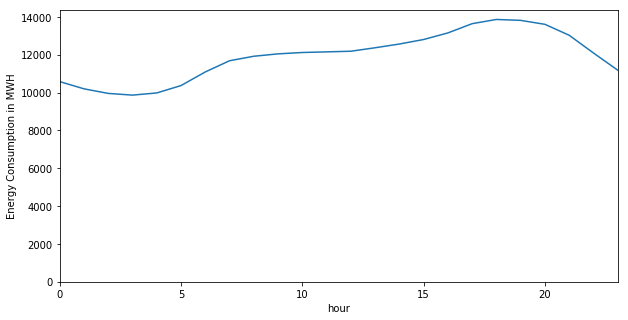

In [24]:
#Plotting average hourly load profile observed over the entire period 
hPGE1418.groupby('hour')['PGE'].mean().plot(figsize=(10,5))
plt.ylabel('Energy Consumption in MWH')
plt.ylim([0,max(hPGE1418.groupby('hour')['PGE'].mean())+500])

#### From the above average hourly load profile graph we can observe how the load remains low over the night and then starts increasing as the city wakes up, and continues increasing during the office hours and peaks in the evening when everyone returns home and turns on their equipment. 

#### Plotting average monthly load profile over the entire period 

(0, 14581.471565134032)

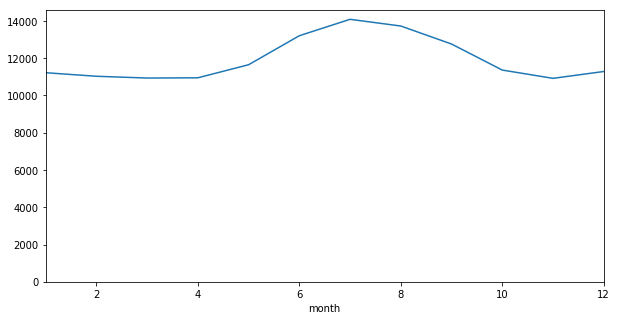

In [25]:
##Plotting average monthly load profile
hPGE1418.groupby('month')['PGE'].mean().plot(figsize=(10,5))
plt.ylim([0,max(hPGE1418.groupby('month')['PGE'].mean())+500])

#### As expected the monthly load profile peaks in the summer due to high cooling load (caused by high temperatures)

#### Plotting the average monthly energy consumption observed for each month over the past 5 years 

In [26]:
#Grouping the dataframe by month and year by applying groupby with an aggregate function of mean; converting the groupby 
#object into a dataframe
df=hPGE1418.groupby(['month','year'])['PGE'].mean()
df=pd.DataFrame(df)

In [27]:
#Unstacking the above dataframe to get the data in a format we can plot
dfun=df.unstack(level='month')
dfun.head()

PGE                                                          \
month            1             2             3             4             5    
year                                                                          
2014   11130.727151  10990.193452  10886.743280  11189.691667  12136.658602   
2015   11149.799731  11023.610119  11099.032258  11273.134722  11447.884409   
2016   11124.299731  10956.158046  11189.133065  11094.477778  11798.236559   
2017   11680.165191  11225.336496  10649.392532  10598.325052  11622.274775   
2018   11000.733271  10938.897023  10831.759148  10564.871736  11222.743280   

                                                                             \
month            6             7             8             9             10   
year                                                                          
2014   13200.812500  14222.637097  13619.041667  12878.006944  11619.841398   
2015   13565.025000  14012.870968  13854.586022  13060.997222  11806.825269   
2016   13508.387500  13978.763441  13722.456989  12737.950000  11284.751344   
2017   13259.959216  14120.702543  14002.638256  12979.197699  11002.596756   
2018   12472.382132  14072.383777  13411.544039  12128.899143  11080.830803   

                                   
month            11            12  
year                               
2014   10829.905556  11214.981183  
2015   11048.977778  11527.083333  
2016   11047.969444  11527.610215  
2017   10842.460013  11287.473975  
2018   10806.323330  10851.220358

In [28]:
#resetting the index to get year as a column 
dfun.reset_index(inplace=True)

In [29]:
#Melting the above dataframe to get the data in the required format to plot average monthly consumption for each month over the 
#past 5 years 
melt=pd.melt(dfun, id_vars='year', value_name='Avg. monthly energy consumption MWH')
melt.head()

,year,None,month,Avg. monthly energy consumption MWH
0,2014,PGE,1,11130.727151
1,2015,PGE,1,11149.799731
2,2016,PGE,1,11124.299731
3,2017,PGE,1,11680.165191
4,2018,PGE,1,11000.733271


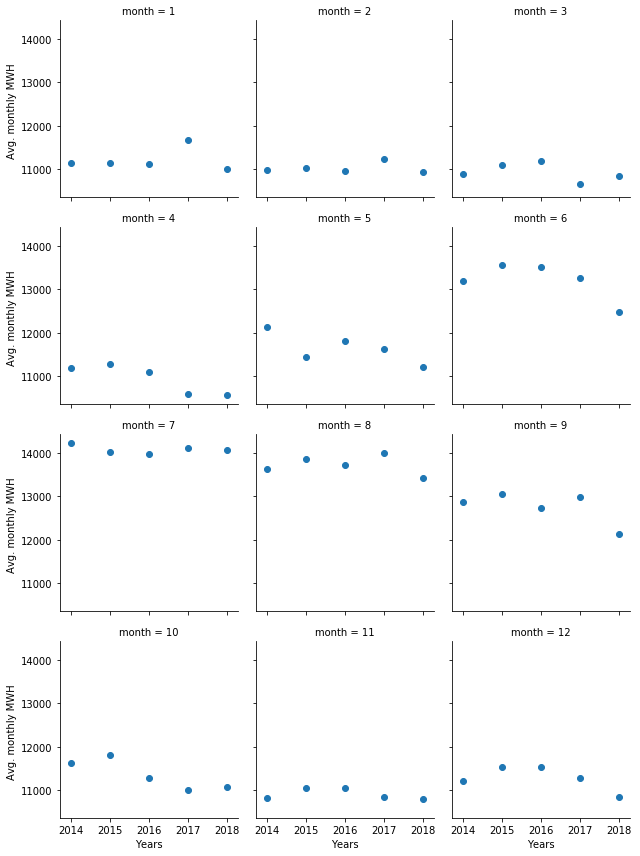

In [30]:
#Plotting each month as a separate graph using Facetgrid
g = sns.FacetGrid(melt, col="month", margin_titles=True, col_wrap=3)
g.map(plt.scatter, "year" ,"Avg. monthly energy consumption MWH");
g.set_axis_labels("Years", "Avg. monthly MWH ");
g.set(ylim=(melt['Avg. monthly energy consumption MWH'].min()-200, melt['Avg. monthly energy consumption MWH'].max()+200));

#### A weak trend can be observed in the data, but it is different for different months. For example, April, May, June, September and October months show a considerable downward trend, whereas other months not so much.

#### Plotting a map of hourly vs weekdays energy consumption to see how the consumption varies across the week

In [31]:
#Using pivot table to create a dataframe having index as hours and columns as weekday and each cell will contain the average
#energy consumption for that particular hour of the weekday
hour_weekday=hPGE1418.pivot_table(values='PGE',index='hour', columns='weekday', aggfunc='mean')

In [32]:
#Ordering the weekdays from Monday to Sunday because the default ordering done by the pivot table is alphabetical
hour_weekday=hour_weekday[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

Text(0.5,1,'Average energy consumption in MWH for each hour of each weekday over the entire period')

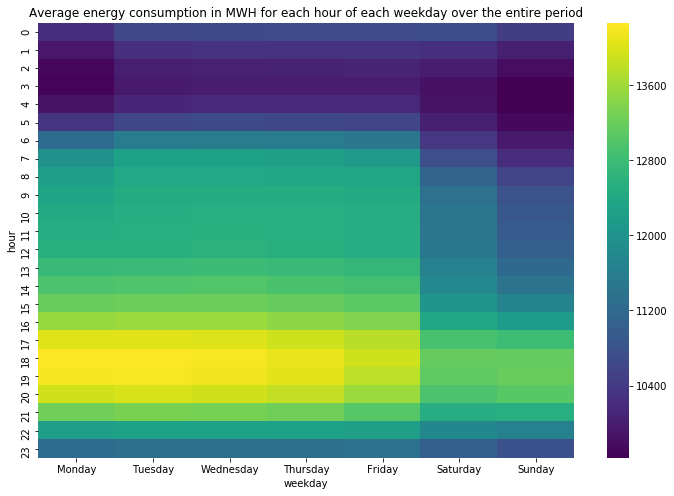

In [33]:
#plotting a heatmap with a colorbar; the colorbar shows the energy consumption in MWH
plt.figure(figsize=(12,8))
sns.heatmap(hour_weekday, cmap='viridis')
plt.title('Average energy consumption in MWH for each hour of each weekday over the entire period')


#### It can be seen that the average consumption from Monday to Friday is below 2000 in the night and it increases during the day and is at peak (>2800) during the evening time before sliding down again for the night. And on the weekends the same pattern can be observed but the overall consumption seems lower on weekends than weekdays as expected because most of the commercial buildings don't operate on weekends (also maybe because people go out on weekends and are not usually at home?)




#### Plotting a histogram to see the overall distribution of the energy consumption for PGE territory 

C:\Users\ppawar\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


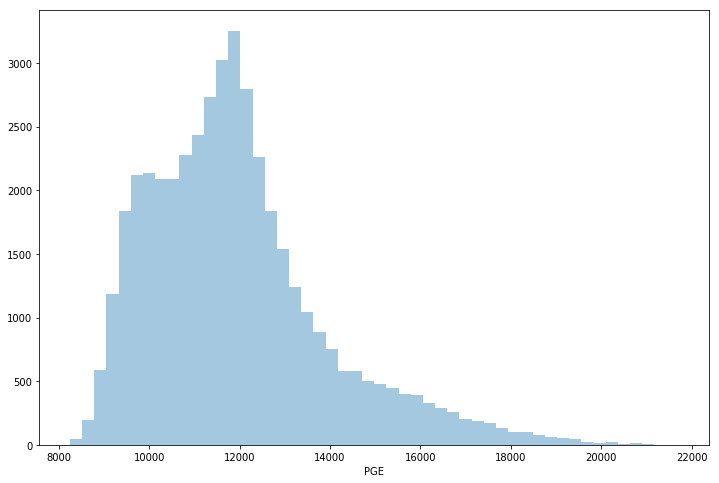

In [34]:
plt.figure(figsize=(12,8))
sns.distplot(hPGE1418['PGE'], kde=False)

#### It can be seen that most of the days (for 2014-18) have energy consumption between ~1700 to ~2500 MWH and the maximum the demand goes is till ~4800MWH

#### Plotting the distribution again but this time using the violon plot and dividing the columns of the plot on the weekdays and adding a hue for working and non-working days

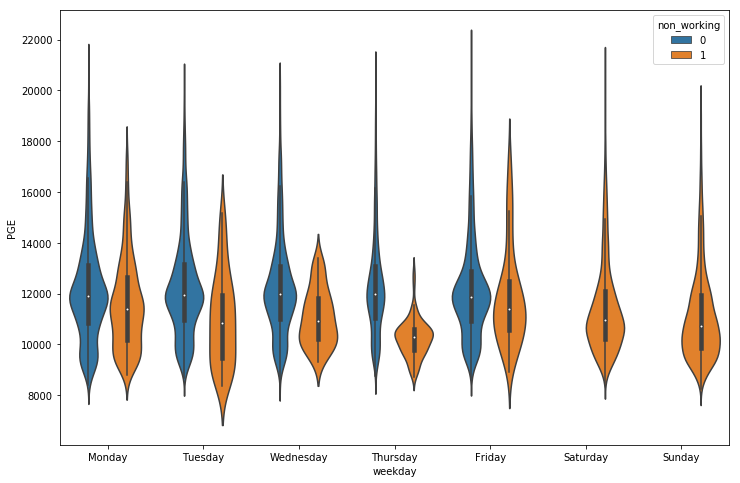

In [35]:
plt.figure(figsize=(12,8))
sns.violinplot(x='weekday', y='PGE', data=hPGE1418, \
               order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], hue='non_working')

#### It can be seen that the median energy consumption remains fairly equal from Monday to Friday and drops on the weekend as seen before in the heatmap. Also, if a particular day is a holiday (indicated in orange) the energy consumption is much lower than if the same day was a working day. 

#### Plotting the same plot as above but this time using box plot and using the months as the x axis. Basically observing the spread and distribution of the energy consumption for each month over the entire period

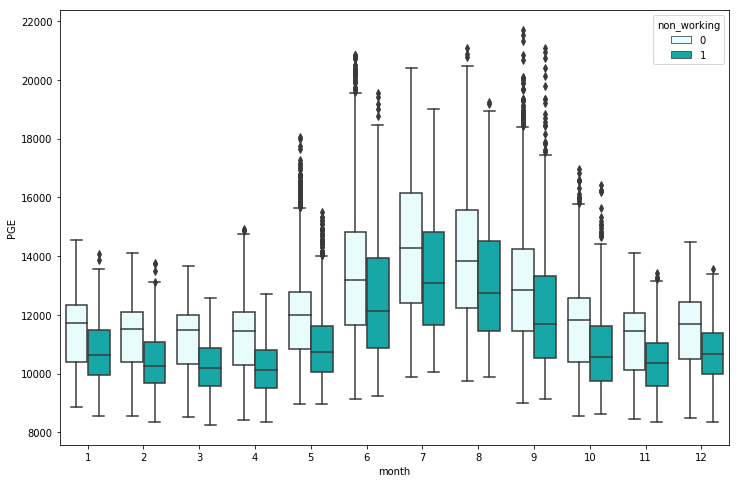

In [36]:
plt.figure(figsize=(12,8))
sns.boxplot(x='month', y='PGE', data=hPGE1418, color='c', hue='non_working')

#### As observed before the energy consumption on non-working days (indicated as 1 or dark green) on an average is always lower than that on the working days. Also, the median energy consumption and also the max peak demand on the grid rise in the summer and we can see that the maximum demand was observed in the month of September at around ~4800MW

#### Visualizing the distribution of energy values for different years 

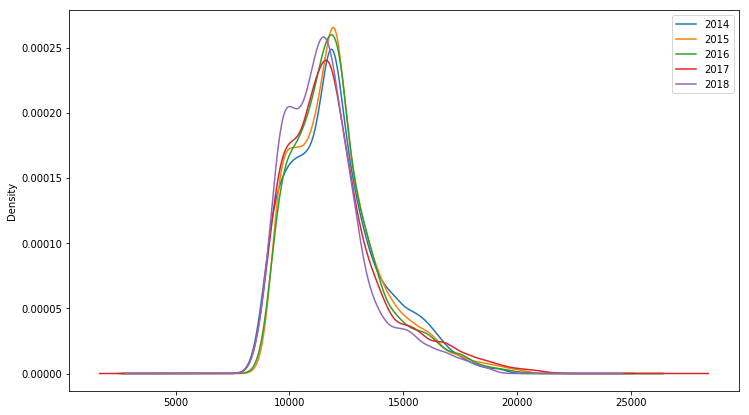

In [37]:
for year in hPGE1418['year'].unique():
    hPGE1418[hPGE1418['year']==year]['PGE'].plot(kind='density', figsize=(12,7), legend=True, label=year)

#### For all the years the distirubtion is kind of bi-modal and the mode values for energy consumption consistently shifts towards left (towards lower energy load) each year from 2014 to 2018

## Further data exploration:
### Other parameters like weather data can be added to see their effect on the energy consumption. Since it was observed that the summer months have the highest energy load (most probably due to high cooling load requirements), it can be expected that the energy consumption will have some correlation with the outside temperature. This can be tested by importing the weather data for the region over similar period and starting with scatter plots with temperature data on one axis and energy on the other. 